# Small Business Owners in the United States

In this project, the focus is on business owners in the United States who fear being turned down or are likely to be turned down for loan collections. 
I start by examining some demographic characteristics of the group, such as age, income category, and debt vs home value. 
Because we are dealing with datatset with a lot of features we select features with high-variance features, and create a clustering model to divide small business owners into subgroups. 

In [1]:
# Import libraries here
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline

### Exploaratory Data Analysis

Import and Prepare Data

Let's start by bringing our data into the project..

In [2]:
df = pd.read_csv("SCFP2019.csv")
print("df shape:", df.shape)
df.head()

df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


We won't have time to explore all of the features in this dataset, but you can look in the [data dictionary](https://github.com/sehmilo/Customer-Segmentation-in-the-US/blob/main/README.md) for this project for details on features used and link to the official [Code Book](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk.htm) of this dataset.

### Explore

As mentioned at the start of this project, we're focusing on business owners. But what percentage of the respondents in the dataframe are business owners?

Here, I Calculate the proportion of respondents in df that are business owners, and assign the result to the variable pct_biz_owners. 

In [3]:
pct_biz_owners = df["HBUS"].value_counts(normalize=True).min()
print("proportion of business owners in df:", pct_biz_owners)

proportion of business owners in df: 0.2740176562229531


Wow, less than 30% percent of the respondents are business owners.

Is the distribution of income different for business owners and non-business owners?. 
Here we explore the Income percentile groups 'INCAAT' column which are categorical data but assigned numerical values from 1-6 to represent the percentile groups.
I created a DataFrame df_inccat that shows the normalized frequency for income categories for business owners and non-business owners.

In [4]:
df["INCCAT"].unique()

array([3, 2, 4, 1, 6, 5], dtype=int64)

In [5]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

df_inccat = df["INCCAT"].replace(inccat_dict).groupby(df["HBUS"]).value_counts(normalize=True).rename("frequency").to_frame().reset_index()

df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


Text(0.5, 1.0, 'Income Distribution: Business Owners vs. Non-Business Owners')

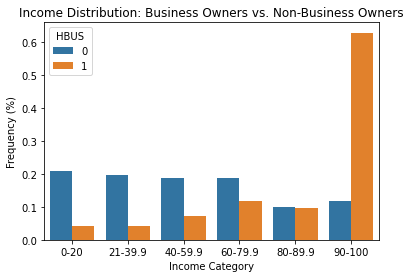

In [6]:
# Create bar chart of `df_inccat`
sns.barplot(
    x= "INCCAT",
    y="frequency",
    hue="HBUS",
    data=df_inccat,
    order=inccat_dict.values()
)
plt.xlabel("Income Category"),
plt.ylabel("Frequency (%)"),
plt.title("Income Distribution: Business Owners vs. Non-Business Owners")


We look at the relationship between home value and household debt in the context of the business owners

- Are there notable differences between business owners and non-business owners?

Using seaborn, I created a scatter plot that shows "HOUSES" vs. "DEBT". Datapoints are colored according to business ownership. 

Text(0.5, 1.0, 'Home Value vs. Household Debt')

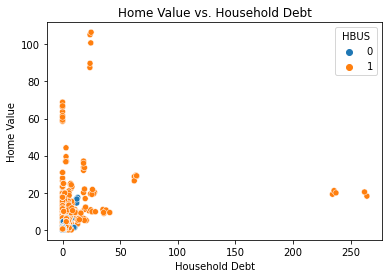

In [7]:
 # Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
    x=df["DEBT"]/ 1e6,
    y=df["HOUSES"]/ 1e6,
    hue=df["HBUS"]
)
plt.xlabel("Household Debt"),
plt.ylabel("Home Value"),
plt.title("Home Value vs. Household Debt")

For the model building part of the project, the focus is on small business owners, defined as respondents who have a business and whose income does not exceed $500,000.
Hence we explore the Total amount of income of household column 'INCOME' and create a new DataFrame df_small_biz that contains only business owners whose income is below $500,000 threshold.

In [8]:
mask = (df["INCOME"] < 500_000) & (df["HBUS"] == 1)
df_small_biz = df[mask]
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (4364, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


In [9]:
# We saw that credit-fearful respondents were relatively young. Is the same true for small business owners?

# Create a histogram from the "AGE" column in df_small_biz with 10 bins. 

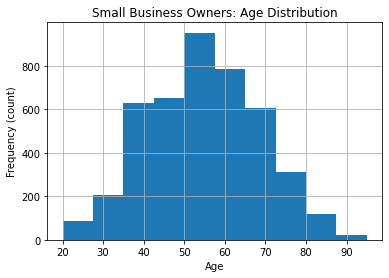

In [10]:
# Plot histogram of "AGE"
df_small_biz["AGE"].hist(bins=10)
plt.xlabel("Age")
plt.ylabel("Frequency (count)")
plt.title("Small Business Owners: Age Distribution");



In [11]:
# So, can we say the same thing about small business owners as we can about credit-fearful people?

In this project, we want to make clusters using more than two features, but which of the 351 features should we choose? Often times, this decision will be made for based on the clients preferered features. For example, a stakeholder could give you a list of the features that are most important to them. If you don't have that limitation, though, another way to choose the best features for clustering is to determine which numerical features have the largest *variance*. That's what we'll do here.


In [12]:
# Calculate variance, get 10 largest features
top_ten_var = df_small_biz.var().sort_values().tail(10)
top_ten_var

EQUITY      1.005088e+13
FIN         2.103228e+13
KGBUS       5.025210e+13
ACTBUS      5.405021e+13
BUS         5.606717e+13
KGTOTAL     6.120760e+13
NHNFIN      7.363197e+13
NFIN        9.244074e+13
NETWORTH    1.424450e+14
ASSET       1.520071e+14
dtype: float64

In [13]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    title="SCF: High Variance Features"
)

fig.update_layout(xaxis_title="Variance", yaxis_title="Features")
fig.show()

### Checking for outliers



In [14]:
# Create a boxplot of `NHNFIN`
fig = px.box(
    data_frame=df_small_biz,
    x=["NHNFIN"],
    title="Distribution of Non-home, Non-Financial Assets"
)
fig.update_layout(xaxis_title="Value [$]")
fig.show()

Whoa! The dataset is massively right-skewed because of the huge outliers on the right side of the distribution. Even though we already excluded households with a high income, the variance is still being distorted by some extreme outliers.

The best way to deal with this is to look at the trimmed variance, where we remove extreme values before calculating variance so as to avoid problems in our calculations. We can do this using the trimmed_variance function from the SciPy library.

- Calculate the trimmed variance for the features in df_small_biz where we remove the top and bottom 10% of observations. 
- Then create a Series top_ten_trim_var with the 10 features with the largest variance.

In [15]:
# Calculate trimmed variance
top_ten_trim_var = df_small_biz.apply(trimmed_var).sort_values().tail(10)
top_ten_trim_var

EQUITY      1.177020e+11
KGBUS       1.838163e+11
FIN         3.588855e+11
KGTOTAL     5.367878e+11
ACTBUS      5.441806e+11
BUS         6.531708e+11
NHNFIN      1.109187e+12
NFIN        1.792707e+12
NETWORTH    3.726356e+12
ASSET       3.990101e+12
dtype: float64

Let's do a quick visualization of those values.

Using plotly express to create a horizontal bar chart of top_ten_trim_var. 

In [16]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="Small Business Owners: High Variance Features"
)
fig.update_layout(xaxis_title="Trimmed Variance [$]", yaxis_title="Feature")
fig.show()

Based on this graph, which five features have the highest variance?

There are three things to also notice in this plot. First, the variances have decreased a lot. In our previous chart, the x-axis went up to $160 Trillion; this one goes up to $4 Trillion. Second, the top 10 features have changed a bit. All the features relating to business ownership ("...BUS") are gone. Finally, we can see that there are big differences in variance from feature to feature. For example, the variance for "EQUITY" is less than $500 billion, while the variance for "ASSET" is nearly $4 billion. In other words, these features have completely different scales. This is something that we'll need to address before we can make good clusters.

I generated a list high_var_cols with the column names of the five features with the highest trimmed variance.

In [17]:
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

### Split

Let's turn that list into a feature matrix.

Create the feature matrix X.

In [18]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)

X shape: (4364, 5)


### Build Model


Now that our data is in order, let's get to work on the model.
One of the issues raised during our EDA after plotting the top ten trimmmed variance, we saw that we had a scale issue among our features. That issue can make it harder to cluster the data, so we'll need to fix that to help our analysis along. One strategy we can use is **standardization**, a statistical method for putting all the variables in a dataset on the same scale. Which we'll incorporate it into our model pipeline.

We Use a for loop to build and train a K-Means model where n_clusters ranges from 2 to 12. 
Each time a model is trained, we calculate the inertia and add it to the list inertia_errors, then calculate the silhouette score and add it to the list silhouette_scores.


In [19]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
   # Build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    
    # Train model
    model.fit(X)
    
    # Calculate Inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate silhoute
    silhouette_scores.append(
        silhouette_score(X, model.named_steps["kmeans"].labels_)
    )

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [5765.863949365048, 3070.4294488357455, 2220.292185089684]

Silhouette Scores: [0.9542706303253067, 0.8446503900103915, 0.7422220122162623]



We can figure out how many clusters we'll need with a line plot based on Inertia and Silhouette scores, more like a joint inversion in geophysics.

We use plotly express to create a line plot that shows the values of inertia_errors as a function of n_clusters. 
You can see that the line starts to flatten out around 3 or 4 clusters, we now use the Silhouette score to validate.

In [20]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")

fig.show()

And let's do the same thing with our Silhouette Scores.
We use plotly express also to create a line plot that shows the values of silhouette_scores as a function of n_clusters.

From this we can see that the best silhouette scores occur when there are 3 clusters.
Putting the information from this plot together with our inertia plot, it seems like the best setting for n_clusters will be 3.

In [21]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(x=n_clusters, y=silhouette_scores, title="K-Means Model: Silhoutter Score vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")


fig.show()

So we build and train a new k-means model named final_model. The number of clusters is now 3 based on information gotten from our inertia errors and silhouette score.

In [22]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
final_model.fit(X)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [23]:
# Communicate

# Create a DataFrame xgb that contains the mean values of the features in X for the 3 clusters in your final_model.

In [24]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,7.367185e+05,1.002199e+06,1.487967e+06,2.076003e+06,2.281249e+06
1,6.874479e+07,8.202115e+07,9.169652e+07,1.134843e+08,1.167529e+08
2,1.216152e+07,1.567619e+07,1.829123e+07,2.310024e+07,2.422602e+07


In [25]:
# As usual, let's make a visualization with the DataFrame.

# Use plotly express to create a side-by-side bar chart from xgb that shows the mean of the features in X for each of the clusters in your final_model. 

In [26]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Small Business Owner Finances by Cluster"
)
fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")


fig.show()

In [27]:
# Remember what we did with higher-dimension data last time? Let's do the same thing here.

# Create a PCA transformer, use it to reduce the dimensionality of the data in X to 2, and then put the transformed data into a DataFrame named X_pca. 
# The columns of X_pca was named "PC1" and "PC2".

In [28]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4364, 2)


,PC1,PC2
0,-6.220648e+06,-503841.638838
1,-6.222523e+06,-503941.888901
2,-6.220648e+06,-503841.638839
3,-6.224927e+06,-504491.429465
4,-6.221994e+06,-503492.598399


In [29]:
# Finally, lets make a visualization of our final DataFrame.

# Use plotly express to create a scatter plot of X_pca using seaborn. 
# Be sure to color the data points using the labels generated by your final_model. 

In [30]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str),
    title="PCA Representation of Clusters"
    
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")

fig.show()